# Assignment


**Installing Simpy**

In [42]:
pip install simpy

**Patient Class**

In [43]:
class Patient(object):
    global INTERARRIVAL_RATE
    global PATIENTS
    global EVENTS

    # constructor of the Patient
    def __init__(self, name, id, env, opr, goesHospital, rejected,fullHospital, int_time):
        global NUM_OF_SICK
        global NUM_OF_SICK_IN_HOSPITAL
        self.env = env      # environment of the simulation
        self.name = name    # name of the patient  
        self.id = id        # id(number) of the patient
        self.arrival_t = self.env.now   # arrival time of the patient
        self.action = env.process(self.call())  # action of patient
        self.goesHospital = goesHospital   # if the patient goes to hospital
        self.rejected = rejected # if the patient is rejected from the hospital 
        self.fullHospital = fullHospital # if the patient should be in hospital before start
        self.int_time = int_time   # interarrival time of the patient
        self.arv_numofsick = NUM_OF_SICK
        self.arv_numofsickinhospital = NUM_OF_SICK_IN_HOSPITAL


        # if the simulation starts with empty hospital, the number of sick people
        # should be increased one by one at each initialization
        if not fullHospital:
          NUM_OF_SICK = NUM_OF_SICK + 1 
          num_of_sick_values.append(NUM_OF_SICK)
          num_of_sick_times.append(self.env.now)
          INTERARRIVAL_RATE = (N-NUM_OF_SICK)/300
    
    # action of the patient
    def call(self):
        global NUM_OF_SICK_IN_HOSPITAL
        global NUM_OF_SICK

        # checks if the patient goes to hospital
        prob = random.uniform(0, 1)
        if prob<=0.2:  
          self.goesHospital = True

        # if the patient directly goes to hospital before starting the simulation (half & full cases)
        if self.goesHospital and self.fullHospital:
            with operator.request() as req:
              yield req
              yield self.env.process(self.heal_athospital())

        # if the patient goes to hospital and there exists an empty bed for her
        elif self.goesHospital and operator.count!=K:
            # number of sick people in hospital increases by 1
          with operator.request() as req:
            yield req
            NUM_OF_SICK_IN_HOSPITAL = NUM_OF_SICK_IN_HOSPITAL + 1
            num_of_sick_in_hospital_values.append(NUM_OF_SICK_IN_HOSPITAL)
            num_of_sick_in_hospital_times.append(self.env.now)
            yield self.env.process(self.heal_athospital())

        # if the patient goes to hospital but there is no empty bed for her
        elif self.goesHospital and operator.count==K:
          self.rejected = True
          yield self.env.process(self.heal_athome())

        # if the patient does not go to hospital
        elif not self.goesHospital:  
          yield self.env.process(self.heal_athome())

    # healing at hospital process     
    def heal_athospital(self):
        global NUM_OF_SICK
        global isSick
        global NUM_OF_SICK_IN_HOSPITAL
        rate =  GOES_HOSPITAL_HEALS_RATE 
        duration = random.expovariate(rate)
        
        yield self.env.timeout(duration)
        EVENTS.append([str(env.now),str(self.id),"Departure",str(NUM_OF_SICK),str(NUM_OF_SICK_IN_HOSPITAL), str(NUM_OF_SICK-NUM_OF_SICK_IN_HOSPITAL)])
        PATIENTS.append([str(self.id),"Hospital",str(self.arv_numofsick),str(self.arv_numofsickinhospital),str(self.int_time),str(self.arrival_t),str(duration),str(self.arrival_t+duration)])
        heal_duration_times.append(duration)
        
        isSick[self.id-1][0] = False
        
        NUM_OF_SICK = NUM_OF_SICK - 1
        num_of_sick_values.append(NUM_OF_SICK)
        num_of_sick_times.append(self.env.now)
        
        NUM_OF_SICK_IN_HOSPITAL = NUM_OF_SICK_IN_HOSPITAL - 1
        num_of_sick_in_hospital_values.append(NUM_OF_SICK_IN_HOSPITAL)
        num_of_sick_in_hospital_times.append(self.env.now)
        INTERARRIVAL_RATE = (N-NUM_OF_SICK)/300
        
     

    # healing at home process
    def heal_athome(self):
        global NUM_OF_SICK
        global NUM_OF_SICK_IN_HOSPITAL
        global isSick
        duration = 0
        # deciding the healing rate 
        if self.rejected:   # healing rate for rejected patient at home
          rate = GOES_HOSPITAL_HEALS_RATE
          duration = random.expovariate(rate) * random.uniform(1,2)
        else:   # healing rate for non-rejected patient at home
          rate = AT_HOME_RATE  
          duration = random.expovariate(rate)

        yield self.env.timeout(duration)  # timeout operation
        EVENTS.append([str(env.now),str(self.id),"Departure",str(NUM_OF_SICK),str(NUM_OF_SICK_IN_HOSPITAL), str(NUM_OF_SICK-NUM_OF_SICK_IN_HOSPITAL)]) 
        PATIENTS.append([str(self.id),"Home",str(self.arv_numofsick),str(self.arv_numofsickinhospital),str(self.int_time),str(self.arrival_t),str(duration),str(self.arrival_t+duration)])
        heal_duration_times.append(duration) 
        NUM_OF_SICK = NUM_OF_SICK - 1 
        isSick[self.id-1][0] = False
        INTERARRIVAL_RATE = (N-NUM_OF_SICK)/300
        num_of_sick_values.append(NUM_OF_SICK)
        num_of_sick_times.append(self.env.now)
        num_of_sick_in_hospital_values.append(NUM_OF_SICK_IN_HOSPITAL)
        num_of_sick_in_hospital_times.append(self.env.now)  



**Patient Generator Function**

In [44]:
import math

# Patient generator function
def patient_generator(env, operator,option):
    global NUM_OF_SICK_IN_HOSPITAL
    global NUM_OF_SICK
    global DAY_NUM
    global isSick
    global N
    global LIMIT
    global EVENTS
     
    dailyCount = 0
    patientCreate = 1 
    index = 1  

    # Initially full or half full hospital case
    while index<LIMIT:
      patient = Patient('Patient %s' %(index), index, env, operator, True, False, True, 0)
      isSick[index-1][0] = True
      isSick[index-1][1] = True
      patientCreate = patientCreate + 1
      EVENTS.append([str(env.now),str(index),"Arrival",str(NUM_OF_SICK),str(NUM_OF_SICK_IN_HOSPITAL), str(NUM_OF_SICK-NUM_OF_SICK_IN_HOSPITAL)])
      index = index + 1

    while True:
        randomId = random.randint(1, patientCreate)
        if isSick[randomId-1][0] is False and isSick[randomId-1][1] is True:
          int_time = random.expovariate(INTERARRIVAL_RATE)
          yield env.timeout(int_time)
          EVENTS.append([str(env.now),str(randomId),"Arrival",str(NUM_OF_SICK),str(NUM_OF_SICK_IN_HOSPITAL), str(NUM_OF_SICK-NUM_OF_SICK_IN_HOSPITAL)])
          patient = Patient('Patient %s' %(randomId), randomId, env, operator, True, False, False,  int_time)
          isSick[randomId-1][0] = True  
        elif patientCreate<N:
          int_time = random.expovariate(INTERARRIVAL_RATE)
          yield env.timeout(int_time)
          EVENTS.append([str(env.now),str(index),"Arrival",str(NUM_OF_SICK),str(NUM_OF_SICK_IN_HOSPITAL), str(NUM_OF_SICK-NUM_OF_SICK_IN_HOSPITAL)])
          patient = Patient('Patient %s' %(index), index, env, operator, False, False, False, int_time) 
          isSick[index-1][0] = True  
          isSick[index-1][1] = True
          patientCreate = patientCreate + 1
          index = index + 1


**Running The Simulation**

In [45]:
import simpy
import random
import math

N = 222 + 123 + 120 + 1000 # calculated N
env = simpy.Environment()  # environment of the simulation
RANDOM_SEED = 978 # random seed
random.seed(RANDOM_SEED)

heal_duration_times = []
num_of_sick_values = []
num_of_sick_times = []
DAY_NUM = 1 # day counter, initially 1
LIMIT = 0   # number of people which should be in hospital before start
PATIENTS = []
EVENTS = []
isSick = [[False,False] for num in range(N)]
NUM_OF_SICK = 0  # number of sick people
NUM_OF_SICK_IN_HOSPITAL = 0  # number of sick people in hospital
num_of_sick_in_hospital_values = []
num_of_sick_in_hospital_times = []
K = math.ceil(N/24)  # number of beds

# option value for the hospital being "Full", "Half" or "Empty"
option = "Empty"
# day option value for 1000, 10000 or 100000
DAY_OPTION = 1000

# adding initial value for three different cases for hospital
if option=="Empty":
  num_of_sick_in_hospital_values.append(0)
  num_of_sick_values.append(0)
elif option=="Half":  
  num_of_sick_in_hospital_values.append(math.ceil(K/2))
  num_of_sick_values.append(math.ceil(K/2))
  NUM_OF_SICK_IN_HOSPITAL = NUM_OF_SICK_IN_HOSPITAL + math.ceil(K/2)
  NUM_OF_SICK = NUM_OF_SICK + math.ceil(K/2) 
  LIMIT = math.ceil(K/2)
elif option=="Full":  
  num_of_sick_in_hospital_values.append(math.ceil(K)) 
  num_of_sick_values.append(math.ceil(K))
  NUM_OF_SICK_IN_HOSPITAL = NUM_OF_SICK_IN_HOSPITAL + K
  NUM_OF_SICK = NUM_OF_SICK + K
  LIMIT = K

num_of_sick_in_hospital_times.append(0) 
num_of_sick_times.append(0)

INTERARRIVAL_RATE = (N-NUM_OF_SICK)/300   # interarrival rate
GOES_HOSPITAL_HEALS_RATE = 1/6          # healing at hospital rate
AT_HOME_RATE = 1/10                     # healing at home rate


operator = simpy.resources.resource.Resource(env, capacity = K) # K beds, meaning K server 


env.process(patient_generator(env, operator,option))
env.run(until=DAY_OPTION)
timef = env.now
print("The simulation has been completed")

The simulation has been completed


**Average Heal Duration Time**

In [46]:
print(sum(heal_duration_times)/len(heal_duration_times))

6.297382702241209


**Total Average Sickness Time**

In [47]:
print(sum(heal_duration_times)/N)

20.79210930425988


**Average Number Of Sick People**

In [48]:
areas = 0
for index, (value, time) in enumerate(zip(num_of_sick_values, num_of_sick_times)):
    if index==len(num_of_sick_values)-1:
      areas = areas + (timef-num_of_sick_times[index])*value
    else:  
      areas = areas + (num_of_sick_times[index+1]-num_of_sick_times[index])*value

print(areas/timef)   # average sick number

30.626342312486297


**Average Number of Occupied Beds in Hospital**

In [49]:
areas = 0
for index, (value, time) in enumerate(zip(num_of_sick_in_hospital_values, num_of_sick_in_hospital_times)):
    if index==len(num_of_sick_in_hospital_values)-1:
      areas = areas + (timef-num_of_sick_in_hospital_times[index])*value
    else:  
      areas = areas + (num_of_sick_in_hospital_times[index+1]-num_of_sick_in_hospital_times[index])*value
  
   
print(areas/timef)   # average number beds occupied in hospital

26.081747058065478


**Long Run Probability of the Hospital Being Empty**

In [50]:
indices = [i for i, x in enumerate(num_of_sick_values) if x == 0]

duration = 0
for index in indices:
  if index==len(num_of_sick_times)-1:
    duration = duration + timef-num_of_sick_in_hospital_times[index]
  else:  
    duration = duration + num_of_sick_times[index+1]-num_of_sick_times[index]

print(duration/timef)

0.0002904047136884414


**Average Proportion of Sick People in Population**


In [51]:
areas = 0
for index, (value, time) in enumerate(zip(num_of_sick_values, num_of_sick_times)):
    if index==len(num_of_sick_values)-1:
      areas = areas + ((timef-num_of_sick_times[index])*value)/N
    else:  
      areas = areas + ((num_of_sick_times[index+1]-num_of_sick_times[index])*value)/N

print(areas/timef)   # average sick number


0.02090535311432515


**Variance of Sick People Values**

In [52]:
import statistics
print(statistics.stdev(num_of_sick_values))

6.74984904705137


**Variance of Occupied Beds in Hospital Values**

In [53]:
import statistics
print(statistics.stdev(num_of_sick_in_hospital_values))

5.633627257552232


**The Table for Events (For the First 50 Events)**

In [54]:
pip install dataframe_image

In [55]:
import pandas as pd
import dataframe_image as dfi
import matplotlib.pylab as plt
from pandas.plotting import table


EVENTS = sorted(EVENTS, key = lambda x: float(x[0]))
df = pd.DataFrame(EVENTS[0:50], columns =['Time', 'ID','Event','Sick #','Hospital #','Home #'])

df.index = df.index + 1
df_styled = df.style.background_gradient() #adding a gradient based on values in cell
df.styled = df.style.set_properties(subset=['Sick #'], **{'width': '600px'})
dfi.export(df_styled,"978_10000_Full_ET.png",table_conversion=None)
df



,Time,ID,Event,Sick #,Hospital #,Home #
1,0.2904047136884414,1,Arrival,0,0,0
2,0.6223084814848152,2,Arrival,1,0,1
3,0.9819343646183519,3,Arrival,2,0,2
4,1.027580290163072,4,Arrival,3,0,3
5,1.0902522315611447,5,Arrival,4,0,4
6,1.1217748890760921,6,Arrival,5,0,5
7,1.5203445235810062,7,Arrival,6,0,6
8,1.5831884871593314,8,Arrival,7,0,7
9,1.624717497217432,9,Arrival,8,0,8
10,1.6674184735321596,10,Arrival,9,0,9


**The Table For Patients**

In [35]:
import pandas as pd
import dataframe_image as dfi
import matplotlib.pylab as plt
from pandas.plotting import table

PATIENTS = sorted(PATIENTS, key = lambda x: float(x[5]))
df = pd.DataFrame(PATIENTS[0:50], columns =['ID', 'Place','Sick #','Hospital #','InterArrival','Arrival','Duration','Departure'])

df.index = df.index + 1
df_styled = df.style.background_gradient() #adding a gradient based on values in cell
df.styled = df.style.set_properties(subset=['Sick #'], **{'width': '600px'})
dfi.export(df_styled,"978_10000_Full_PT.png",table_conversion=None)
df

,ID,Place,Sick #,Hospital #,InterArrival,Arrival,Duration,Departure
1,45,Hospital,62,62,0,0,0.03586171964128584,0.03586171964128584
2,22,Hospital,62,62,0,0,0.14747233052036693,0.14747233052036693
3,55,Hospital,62,62,0,0,0.3398495874489467,0.3398495874489467
4,37,Hospital,62,62,0,0,0.4542767778207623,0.4542767778207623
5,43,Hospital,62,62,0,0,0.5395018342564907,0.5395018342564907
6,24,Hospital,62,62,0,0,0.844219749588772,0.844219749588772
7,12,Hospital,62,62,0,0,1.0270828582059006,1.0270828582059006
8,10,Hospital,62,62,0,0,1.0409603515677301,1.0409603515677301
9,61,Hospital,62,62,0,0,1.1292282626788435,1.1292282626788435
10,8,Hospital,62,62,0,0,1.308338551165066,1.308338551165066


**Plotting Of The Number of Occupied Beds in Hospital**

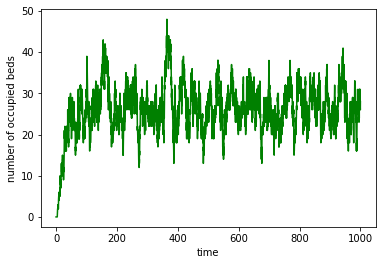

In [40]:
import matplotlib.pyplot as plt

plt.plot(num_of_sick_in_hospital_times, num_of_sick_in_hospital_values, c='green')
plt.xlabel("time")
plt.ylabel("number of occupied beds")
plt.show()

**Plotting of The Number of Sick People**

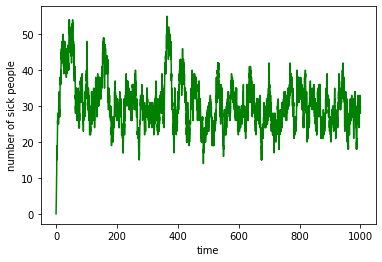

In [41]:
import matplotlib.pyplot as plt

plt.plot(num_of_sick_times, num_of_sick_values, c='green')
plt.xlabel("time")
plt.ylabel("number of sick people")
plt.show()